Implementation of an accelerated version of the Blahut Arimoto algorithm (BAA).
The goal of this algorithm is to maximize mutual information over discrete input distributions.
Mutual information is given by

$$I(X;Y) = \mathsf{D}_{\mathsf{KL}}(P_{XY}\|P_X\otimes P_Y):=\sum_{(x,y)\in\mathcal{X}\times \mathcal{Y}}p(x,y)\log \frac{p(x,y)}{p(x)p(y)}$$

We assume that $|\mathcal{Y}|<\infty$ and the channel is therefore given by a transition matrix that represents $p(y|x)$.

All versions of the BAA consist of iteratively alternating between two steps. Denote by $p_r$ the input PMF on the $r$th iteration. An iteration consists of:


1.   Calculation some measure that describes the model according to $p^r$.
2.   Calculation of $p^{r+1}$ according to $p^r$ and the calculated measure. 


This notebook provides an accelerated implementation of BAA that relies of the calculation of the the KL divergence terms induced by the model.
We define the following term:
$$
D(x) := \mathsf{D}_{\mathsf{KL}}(P_{Y|X=x}\|P_Y)
$$
To this end, the above steps boil down to:


1.   Calculate $(D(x))_{x\in\mathcal{X}}$
2.   Update PMF according to the rule: 
$p^{r+1}(x) = \frac{e^{D(x)}p^r(x)}{\sum_{x'\in\mathcal{X}}e^{D(x')}p^r(x')}$



Start with importing relevant packages:

In [184]:
import numpy as np
from scipy.special import softmax
import matplotlib.pyplot as plt

Define channel matrix generators:

In [185]:
def clean_channel():
  # clean channel
  p0 = [0,1]
  p1 = [1,0]
  p_ygx = np.asarray([p0,p1])
  return p_ygx

def bsc(p):
  # clean channel
  p0 = [1-p,p]
  p1 = [p,1-p]
  p_ygx = np.asarray([p0,p1])
  return p_ygx

def bec(delta):
  p0 = [1-delta, 0, delta]
  p1 = [0, 1-delta, delta]
  p_ygx = np.asarray([p0,p1])
  return p_ygx

Define the BA algorithm as a python class

In [186]:
class BA(object):
  def __init__(self,alphabet_size, channel_name, p=0.5):
    self.m = alphabet_size
    self.gen_channel_mat(channel_name, p)
    self.pmf = np.squeeze(softmax(np.random.uniform(size=[alphabet_size,1], low=0, high=10)))
    self.pmf_history = [self.pmf]
    self.TV_err_history = []
    self.KLD_err_history = []
    self.MI_history = []
    self.total_iter = 20

  def train(self,tolerance=1e-20):
    for i in range(self.total_iter):
      # train the algorithm
      Dx = self.information_step()
      self.pmf_step(Dx)
      print('Iteration {}, TV error = {}, MI = {}[bits]'.format(i, self.TV_err_history[-1], self.MI/np.log(2)))
      # if self.TV_err_history[-1]<tolerance:
      #   break

  def gen_channel_mat(self,channel_name, p=0.5):
    if channel_name == 'clean':
      self.channel_mat = clean_channel()
    elif channel_name == 'bsc':
      self.channel_mat = bsc(p)
    elif channel_name == 'bec':
      self.channel_mat = bec(p)
    else:
      raise ValueError("'{}' is an invalid channel name")

  def present_results(self):
    # show the eperiment resutls in considered metrics

    plt.figure()
    plt.plot(range(self.total_iter), self.TV_err_history)
    plt.title('Total variation error of PMF between consecutive iterations')
    plt.xlabel('Iteration')
    plt.ylabel('TV error')

    plt.figure()
    plt.plot(range(self.total_iter), self.KLD_err_history/np.log(2))
    plt.title('KL divergence of PMF between consecutive iterations')
    plt.xlabel('Iteration')
    plt.ylabel('KL divergence[bits]')

    plt.figure()
    plt.plot(range(self.total_iter), self.MI_history/np.log(2))
    plt.title('Mutual information vs. iteration')
    plt.xlabel('Iteration')
    plt.ylabel('Mutual information[bits]')


    

  def information_step(self):
    self.py = np.matmul(self.pmf, self.channel_mat)
    Dx = []
    for i in range(self.m):
      Dx.append(np.matmul(self.channel_mat[i], np.log(self.channel_mat[i]/self.py+1e-15)))
    return Dx

  def pmf_step(self,Dx):
    mult = self.pmf * np.exp(Dx)
    px_ = mult/np.sum(mult)
    self.pmf_history.append(px_)
    self.TV_err_history.append(self.calcualte_TV([self.pmf, px_]))
    self.KLD_err_history.append(self.calculate_KLD(self.pmf, px_))
    self.MI = np.matmul(self.pmf,Dx)
    self.MI_history.append(self.MI)
    self.pmf = px_

  def calcualte_TV(self,p):
    return np.sum(np.abs(p[0]-p[1]))
  
  def calculate_KLD(self,p1,p2):
    llr = np.log((p1+1e-15)/(p2+1e-15))
    return np.matmul(p1,llr)

Define parameters and initialize an instance of the BAA

In [187]:
m = 2
channel_name = 'bec'
p = 0.1  
tolerance = 0

trainer = BA(alphabet_size=m, channel_name=channel_name, p=p)

Rune the algorithm with given tolerance

In [188]:
trainer.train(0)

Iteration 0, TV error = 0.33424821274366007, MI = 0.8072140676060493[bits]
Iteration 1, TV error = 0.035300697453398755, MI = 0.8990008537154662[bits]
Iteration 2, TV error = 0.0035320612144348895, MI = 0.8999900009190879[bits]
Iteration 3, TV error = 0.0003532081141405796, MI = 0.8999999000084293[bits]
Iteration 4, TV error = 3.532081340684723e-05, MI = 0.899999999000085[bits]
Iteration 5, TV error = 3.5320813426831243e-06, MI = 0.8999999999900019[bits]
Iteration 6, TV error = 3.532081341850457e-07, MI = 0.899999999999901[bits]
Iteration 7, TV error = 3.532081349622018e-08, MI = 0.9[bits]
Iteration 8, TV error = 3.5320811275774133e-09, MI = 0.9000000000000008[bits]
Iteration 9, TV error = 3.532082959445404e-10, MI = 0.9000000000000008[bits]
Iteration 10, TV error = 3.5320857350029655e-11, MI = 0.9000000000000009[bits]
Iteration 11, TV error = 3.5320080193912418e-12, MI = 0.9000000000000008[bits]
Iteration 12, TV error = 3.532729664357248e-13, MI = 0.9000000000000008[bits]
Iteration 13

Present collected metrics

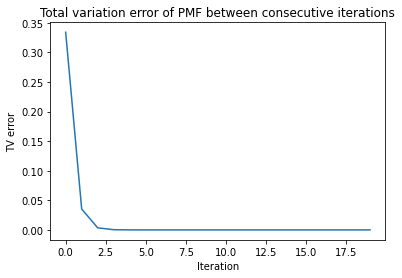

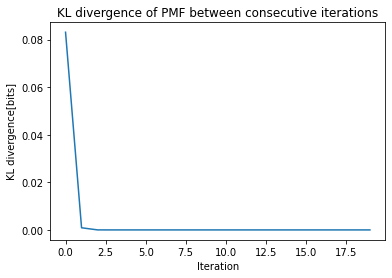

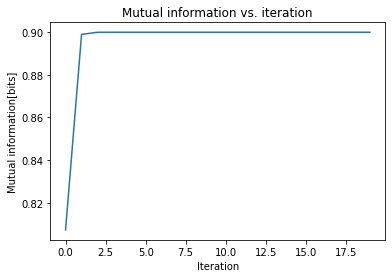

In [189]:
trainer.present_results()